In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from utility import helpers
from utility import scoring

#import warnings
#warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

: 

### 2025 Schedule

In [3]:
sched_data = helpers.get_schedule()
sched_data = helpers.clean_schedule(sched_data)

In [4]:
sched_data

,TEAM,Week,Opponent,Location,Game_Type
0,ARI,1,NO,Away,Game
32,ARI,2,CAR,Home,Game
64,ARI,3,SF,Away,Game
96,ARI,4,SEA,Home,Game
128,ARI,5,TEN,Home,Game
...,...,...,...,...,...
447,WSH,14,MIN,Away,Game
479,WSH,15,NYG,Away,Game
511,WSH,16,PHI,Home,Game
543,WSH,17,DAL,Home,Game


### QB MODEL

In [2]:
pos = 'QB'
qb_data = helpers.get_position_data(pos)
qb_data = helpers.clean_offense_data(qb_data, pos=pos)
qb_data.head(3)

/Users/justin/Desktop/chest/fantasy_football/2025/utility/helpers.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype(str)
/Users/justin/Desktop/chest/fantasy_football/2025/utility/helpers.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].apply(lambda x: x.strip() if x is str else x)
/Users/justin/Desktop/chest/fantasy_football/2025/utility/helpers.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Name,Position,Team,Opp,Week,PassYds,PassTD,Int,RushYds,RushTD,Fum,ModelPoints
0,Josh Allen,QB,BUF,BAL,1.0,238.18,1.70,0.69,31.93,0.63,0.19,23.34
1,Jayden Daniels,QB,WAS,NYG,1.0,232.47,1.62,0.69,47.14,0.37,0.19,22.30
2,Lamar Jackson,QB,BAL,@BUF,1.0,217.68,1.80,0.54,47.15,0.23,0.24,21.84


In [5]:
QB_DATA = qb_data.copy(deep=True)
qb_data = qb_data[qb_data['ModelPoints'] > 5]

# 1. Distribution of Passing Yards
plt.figure(figsize=(10, 6))
sns.histplot(qb_data['PassYds'], kde=True, bins=30)
plt.title('Distribution of Passing Yards')
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.show()

# 2. Correlation Matrix
corr_data = qb_data.loc[:, ['Week', 'PassYds', 'PassTD', 'Int']]
correlation_matrix = corr_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 3. Boxplot of Passing Yards by Opponent
plt.figure(figsize=(12, 8))
sns.boxplot(x='Opp', y='PassYds', data=qb_data)
plt.title('Passing Yards by Opponent')
plt.xticks(rotation=90)
plt.show()

# 4. Boxplot of Passing Yards by QB
plt.figure(figsize=(12, 8))
sns.boxplot(x='Name', y='PassYds', data=qb_data)
plt.title('Passing Yards by QB')
plt.xticks(rotation=90)
plt.show()


AttributeError: module 'seaborn' has no attribute 'histplot'

<Figure size 720x432 with 0 Axes>

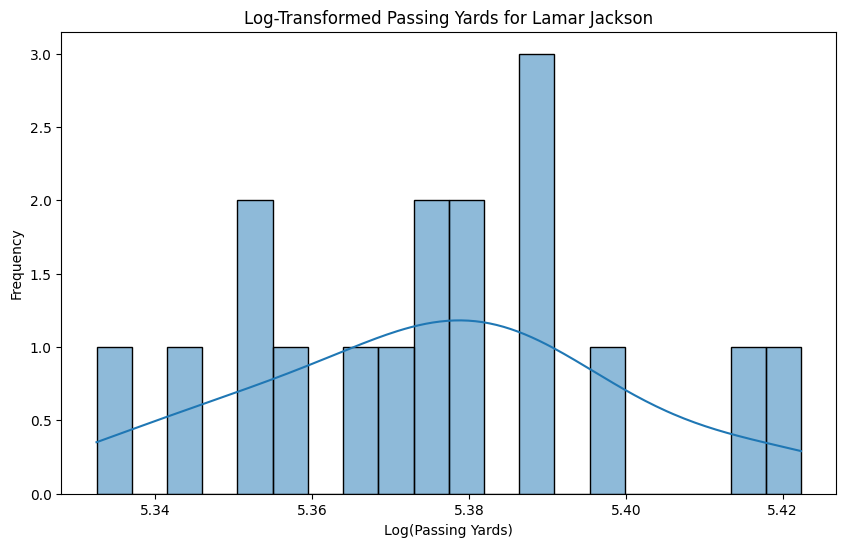

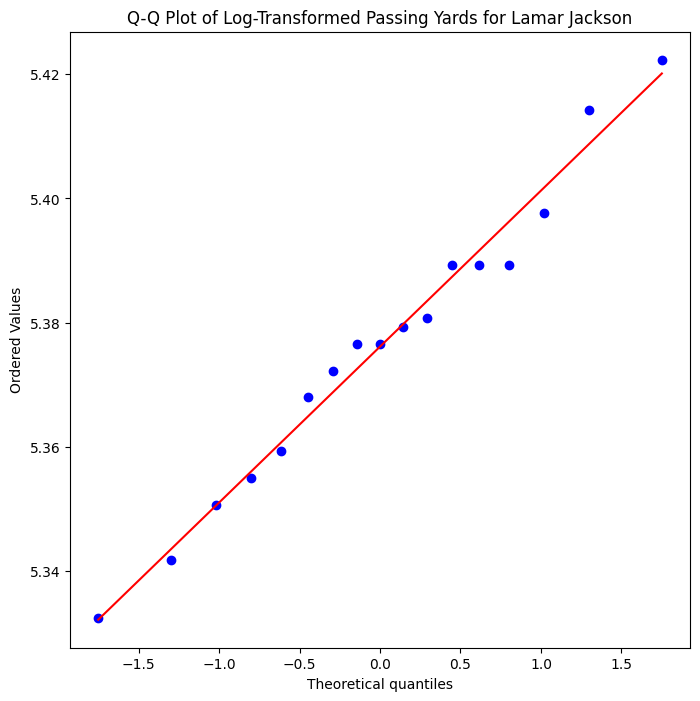

Shapiro-Wilk test for normality: W=0.9816796778390053, p-value=0.9708171542176676
Kolmogorov-Smirnov test for normality: D=0.11564122560604462, p-value=0.9569404938823391


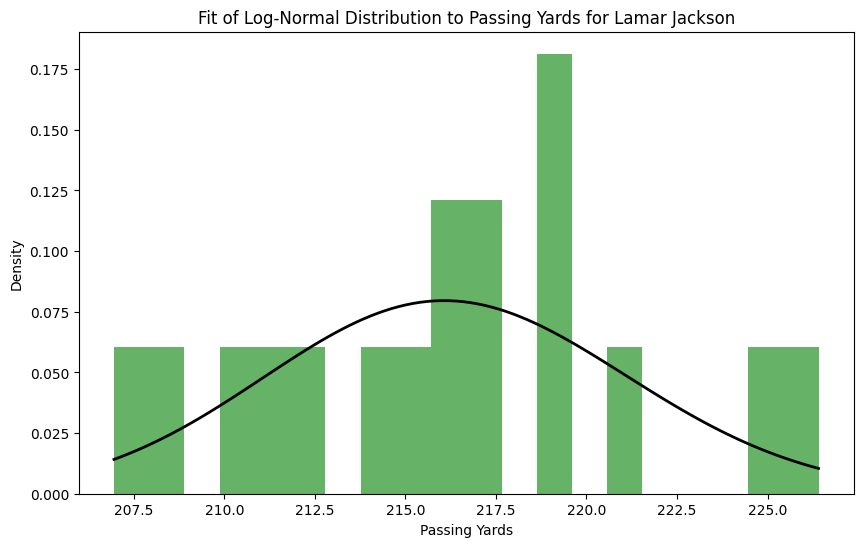

In [ ]:

QUARTERBACKS = list(qb_data['Name'].unique().tolist())
def random_qb(qbs=QUARTERBACKS) -> str: return str(qbs[random.randint(0, len(qbs)-1)])

# Step 1: Filter data for a specific player (replace 'Player Name' with the actual player's name)
player_name = random_qb()
player_data = qb_data[qb_data['Name'] == player_name]['PassYds']

# Step 2: Apply log transformation
log_passing_yds = np.log(player_data)

# Step 3: Visual Inspection
# Histogram of log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(log_passing_yds, kde=True, bins=20)
plt.title(f'Log-Transformed Passing Yards for {player_name}')
plt.xlabel('Log(Passing Yards)')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot for log-transformed data
plt.figure(figsize=(8, 8))
stats.probplot(log_passing_yds, dist="norm", plot=plt)
plt.title(f'Q-Q Plot of Log-Transformed Passing Yards for {player_name}')
plt.show()

# Step 4: Statistical Tests
# Shapiro-Wilk test
shapiro_test = stats.shapiro(log_passing_yds)
print(f'Shapiro-Wilk test for normality: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

# Kolmogorov-Smirnov test
ks_test = stats.kstest(log_passing_yds, 'norm', args=(log_passing_yds.mean(), log_passing_yds.std()))
print(f'Kolmogorov-Smirnov test for normality: D={ks_test.statistic}, p-value={ks_test.pvalue}')

# Step 5: Fitting a log-normal distribution to the original data
shape, loc, scale = stats.lognorm.fit(player_data, floc=0)
x = np.linspace(player_data.min(), player_data.max(), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(10, 6))
plt.hist(player_data, bins=20, density=True, alpha=0.6, color='g')
plt.plot(x, pdf, 'k', linewidth=2)
plt.title(f'Fit of Log-Normal Distribution to Passing Yards for {player_name}')
plt.xlabel('Passing Yards')
plt.ylabel('Density')
plt.show()


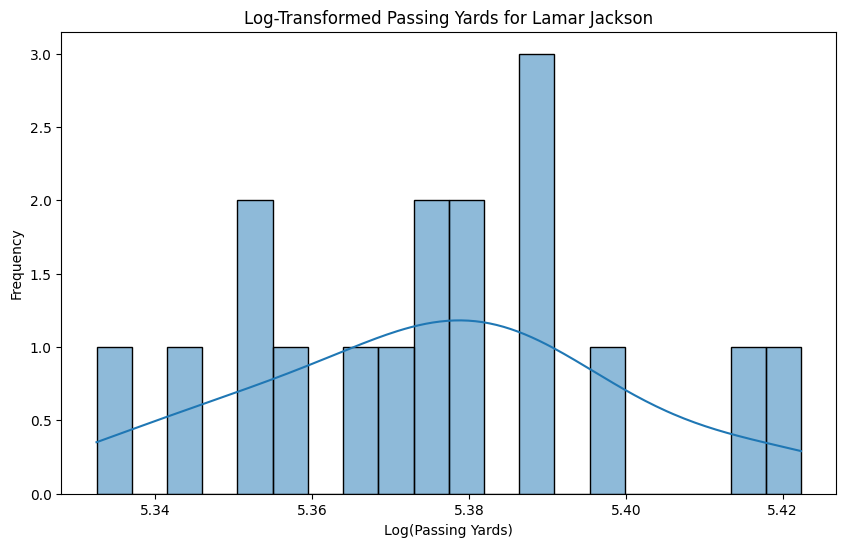

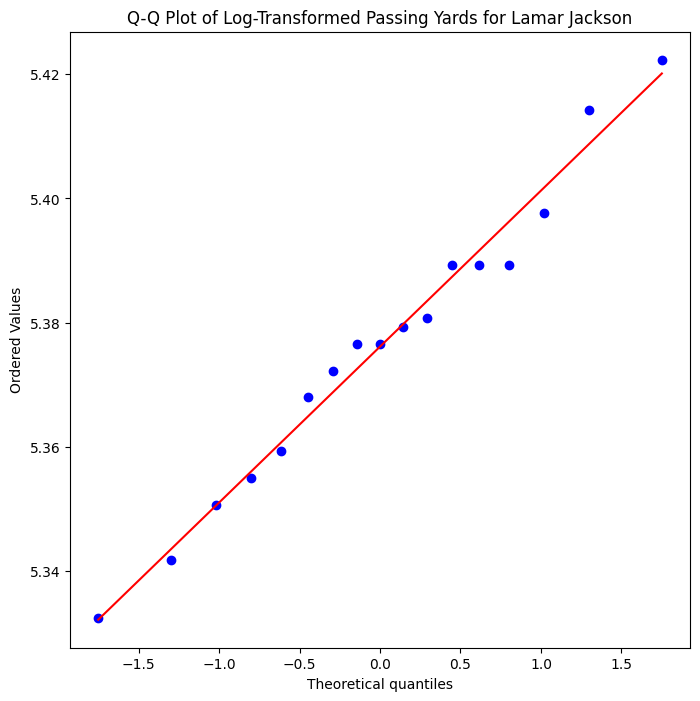

Shapiro-Wilk test for normality: W=0.9816796778390053, p-value=0.9708171542176676
Kolmogorov-Smirnov test for normality: D=0.11564122560604462, p-value=0.9569404938823391


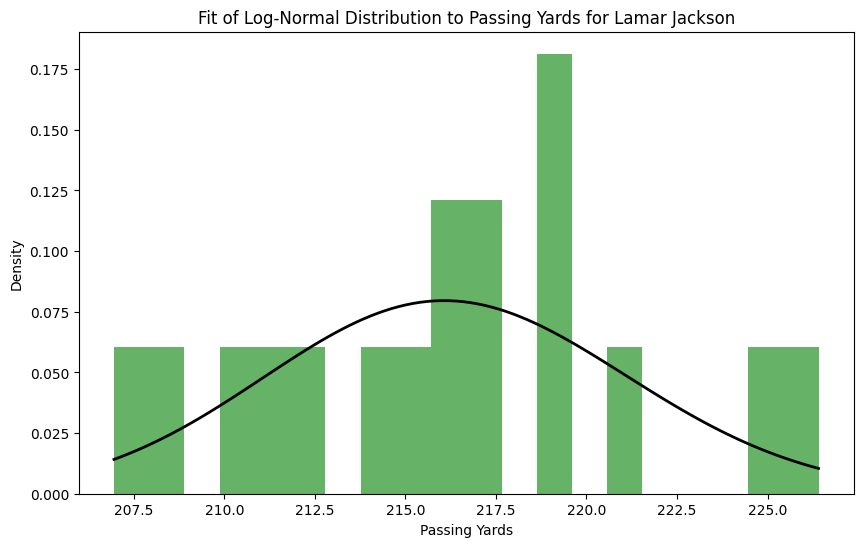

In [5]:

QUARTERBACKS = list(qb_data['Name'].unique().tolist())
def random_qb(qbs=QUARTERBACKS) -> str: return str(qbs[random.randint(0, len(qbs)-1)])

# Step 1: Filter data for a specific player (replace 'Player Name' with the actual player's name)
player_name = random_qb()
player_data = qb_data[qb_data['Name'] == player_name]['PassYds']

# Step 2: Apply log transformation
log_passing_yds = np.log(player_data)

# Step 3: Visual Inspection
# Histogram of log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(log_passing_yds, kde=True, bins=20)
plt.title(f'Log-Transformed Passing Yards for {player_name}')
plt.xlabel('Log(Passing Yards)')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot for log-transformed data
plt.figure(figsize=(8, 8))
stats.probplot(log_passing_yds, dist="norm", plot=plt)
plt.title(f'Q-Q Plot of Log-Transformed Passing Yards for {player_name}')
plt.show()

# Step 4: Statistical Tests
# Shapiro-Wilk test
shapiro_test = stats.shapiro(log_passing_yds)
print(f'Shapiro-Wilk test for normality: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

# Kolmogorov-Smirnov test
ks_test = stats.kstest(log_passing_yds, 'norm', args=(log_passing_yds.mean(), log_passing_yds.std()))
print(f'Kolmogorov-Smirnov test for normality: D={ks_test.statistic}, p-value={ks_test.pvalue}')

# Step 5: Fitting a log-normal distribution to the original data
shape, loc, scale = stats.lognorm.fit(player_data, floc=0)
x = np.linspace(player_data.min(), player_data.max(), 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(10, 6))
plt.hist(player_data, bins=20, density=True, alpha=0.6, color='g')
plt.plot(x, pdf, 'k', linewidth=2)
plt.title(f'Fit of Log-Normal Distribution to Passing Yards for {player_name}')
plt.xlabel('Passing Yards')
plt.ylabel('Density')
plt.show()


Finding distribution for: Caleb Williams
Normal: KS Statistic = 0.10847379522238038, p-value = 0.9751938967605663
LogNormal: KS Statistic = 0.10847590576343674, p-value = 0.9751894325744752
Exponential: KS Statistic = 0.3083954784970927, p-value = 0.06213784976393044
Gamma: KS Statistic = 0.11909299307543841, p-value = 0.9459491926712528
Weibull: KS Statistic = 0.08119378219421464, p-value = 0.9993520845758858
Logistic: KS Statistic = 0.08326490352114102, p-value = 0.9990281970194562
t-Distribution: KS Statistic = 0.10799697947138653, p-value = 0.9761889288843018


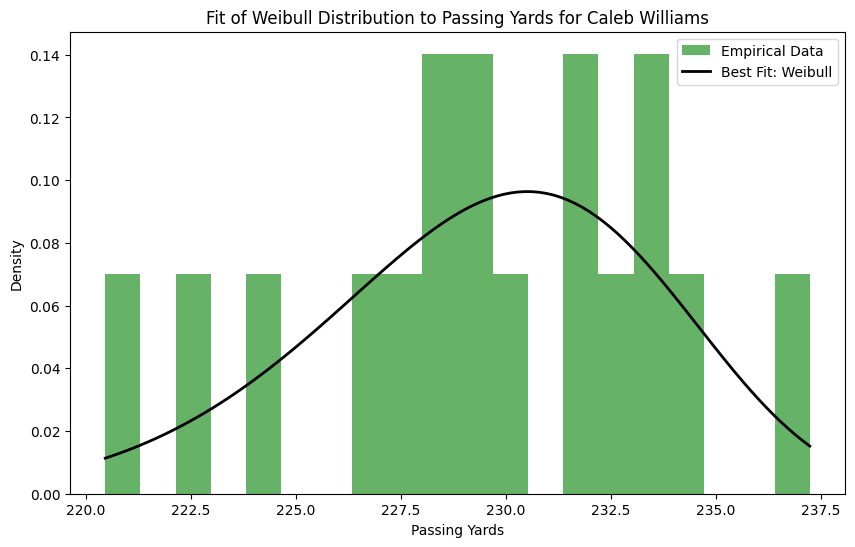

In [6]:

QUARTERBACKS = list(qb_data['Name'].unique().tolist())
def random_qb(qbs=QUARTERBACKS) -> str: return str(qbs[random.randint(0, len(qbs)-1)])

# Step 1: Filter data for a specific player (replace 'Player Name' with the actual player's name)
player_name = random_qb()

print(f"Finding distribution for: {player_name}")

player_data = qb_data[qb_data['Name'] == player_name]['PassYds']

# Step 2: Define distributions to test
distributions = {
    'Normal': stats.norm,
    'LogNormal': stats.lognorm,
    'Exponential': stats.expon,
    'Gamma': stats.gamma,
    'Weibull': stats.weibull_min,
    'Logistic': stats.logistic,
    't-Distribution': stats.t
}

# Step 3: Fit each distribution and calculate goodness-of-fit
best_fit_name = None
best_fit_params = None
best_fit_stat = np.inf
best_fit_dist = None

for name, distribution in distributions.items():
    params = distribution.fit(player_data)
    
    # Perform the Kolmogorov-Smirnov test
    ks_stat, ks_p_value = stats.kstest(player_data,distribution.cdf,args=params)
    
    # Check if this distribution is a better fit (lower KS statistic)
    if ks_stat < best_fit_stat:
        best_fit_name = name
        best_fit_params = params
        best_fit_stat = ks_stat
        best_fit_dist = distribution

    print(f'{name}: KS Statistic = {ks_stat}, p-value = {ks_p_value}')

# Step 4: Visualize the best fit
x = np.linspace(min(player_data), max(player_data), 100)
pdf = best_fit_dist.pdf(x, *best_fit_params)

plt.figure(figsize=(10, 6))
plt.hist(player_data, bins=20, density=True, alpha=0.6, color='g', label='Empirical Data')
plt.plot(x, pdf, 'k', linewidth=2, label=f'Best Fit: {best_fit_name}')
plt.title(f'Fit of {best_fit_name} Distribution to Passing Yards for {player_name}')
plt.xlabel('Passing Yards')
plt.ylabel('Density')
plt.legend()
plt.show()

In [7]:
qb_points_data = qb_data.copy(deep=True)
# Apply the points function to each row

qb_points_data['Points'] = qb_points_data.apply(scoring.calculate_qb_points, axis=1)

# Group by Name and sum points by player
grouped = qb_points_data.groupby('Name').agg({'Points': ['sum', 'count']})

# Display weekly points and the sum of points for each player
for name, group in qb_points_data.groupby('Name'):
    print(f"{name} Weekly Points:")
    print(group[['Week', 'Points']])
    print(f"Total Points: {group['Points'].sum()}")
    print("-" * 30)

# To display the grouped and summed data
print(grouped)

Aaron Rodgers Weekly Points:
     Week  Points
22    1.0   15.41
43    2.0   16.92
65    3.0   17.07
91    4.0   16.98
114   5.0   16.98
139   6.0   17.01
167   7.0   16.71
193   8.0   16.83
215   9.0   16.98
240  10.0   17.07
265  11.0   17.07
316  13.0   17.13
338  14.0   16.77
366  15.0   16.86
391  16.0   17.13
420  17.0   15.65
440  18.0   16.98
Total Points: 285.55
------------------------------
Anthony Richardson Weekly Points:
     Week  Points
5     1.0   18.35
30    2.0   18.14
54    3.0   19.53
80    4.0   18.26
104   5.0   18.26
128   6.0   18.35
154   7.0   19.50
181   8.0   18.20
205   9.0   18.35
230  10.0   18.26
256  11.0   18.11
279  12.0   18.26
304  13.0   18.35
355  15.0   18.41
379  16.0   19.59
405  17.0   18.35
429  18.0   19.56
Total Points: 315.83
------------------------------
Baker Mayfield Weekly Points:
     Week  Points
18    1.0   16.87
47    2.0   15.27
71    3.0   15.51
96    4.0   15.39
119   5.0   15.27
143   6.0   15.27
170   7.0   15.27
195   8.0  

### Create master points and auction values sheet

In [8]:
pos = 'QB'
qb_data_w_scoring = helpers.get_position_data(pos)
qb_data_w_scoring = helpers.clean_offense_data(qb_data_w_scoring, pos=pos)

pos = 'RB'
rb_data_w_scoring = helpers.get_position_data(pos)
rb_data_w_scoring = helpers.clean_offense_data(rb_data_w_scoring, pos=pos)

pos = 'WR'
wr_data_w_scoring = helpers.get_position_data(pos)
wr_data_w_scoring = helpers.clean_offense_data(wr_data_w_scoring, pos=pos)

pos = 'TE'
te_data_w_scoring = helpers.get_position_data(pos)
te_data_w_scoring = helpers.clean_offense_data(te_data_w_scoring, pos=pos)

qb_data_w_scoring['ModelPoints'] = qb_data_w_scoring.apply(scoring.calculate_qb_points, axis=1)
rb_data_w_scoring['ModelPoints'] = rb_data_w_scoring.apply(scoring.calculate_rb_wr_points, axis=1)
wr_data_w_scoring['ModelPoints'] = wr_data_w_scoring.apply(scoring.calculate_rb_wr_points, axis=1)
te_data_w_scoring['ModelPoints'] = te_data_w_scoring.apply(scoring.calculate_te_points, axis=1)

merge_all = pd.concat([qb_data_w_scoring, rb_data_w_scoring, wr_data_w_scoring, te_data_w_scoring], ignore_index=True)
merge_all.to_csv('all_data.csv', index=False)
grouped_data = merge_all.groupby('Name').agg({'ModelPoints': ['sum', 'count']})
grouped_data.to_csv('grouped_data.csv', index=True)

In [9]:
qb_data_w_scoring.head(5)

,Name,Position,Team,Opp,Week,PassYds,PassTD,Int,RushYds,RushTD,Fum,ModelPoints
0,Josh Allen,QB,BUF,ARI,1.0,256.85,1.72,0.89,34.90,0.57,0.25,26.32
1,Jalen Hurts,QB,PHI,GB,1.0,224.94,1.34,0.67,39.60,0.67,0.18,20.51
2,Patrick Mahomes,QB,KC,BAL,1.0,283.29,2.00,0.73,22.11,0.12,0.24,25.81
3,Lamar Jackson,QB,BAL,@KC,1.0,206.95,1.48,0.59,51.37,0.32,0.23,21.34
4,C.J. Stroud,QB,HOU,@IND,1.0,275.96,2.09,0.76,12.00,0.12,0.19,25.41


In [10]:
def calculate_vorp_and_rank(group):
    position = group['Position'].iloc[0]
    if position == 'QB':
        baseline = group['ModelPoints'].nlargest(18).iloc[-1]
    elif position in ['RB', 'WR']:
        baseline = group['ModelPoints'].nlargest(48).iloc[-1]
    elif position == 'TE':
        baseline = group['ModelPoints'].nlargest(18).iloc[-1]
    else:
        baseline = 0  # For any other positions
    
    group['VORP'] = group['ModelPoints'] - baseline
    
    # Add ranking
    group['Rank'] = group['ModelPoints'].rank(method='min', ascending=False)
    
    return group

# Apply the function to each group
grouped_vorp_and_rank_data = merge_all.groupby(['Week', 'Position']).apply(calculate_vorp_and_rank).reset_index(drop=True)

grouped_vorp_and_rank_data = grouped_vorp_and_rank_data.sort_values(['Week', 'Position', 'Rank'])

# Display the VORP and rank data.
grouped_vorp_and_rank_data.head(10)

/var/folders/p3/svv3_rhn7mlfyw2x0bgcq_k40000gn/T/ipykernel_37765/2830130251.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_vorp_and_rank_data = merge_all.groupby(['Week', 'Position']).apply(calculate_vorp_and_rank).reset_index(drop=True)


,Name,Position,Team,Opp,Week,PassYds,PassTD,Int,RushYds,RushTD,Fum,ModelPoints,Rec,RecYds,RecTD,VORP,Rank
0,Josh Allen,QB,BUF,ARI,1.0,256.85,1.72,0.89,34.90,0.57,0.25,26.32,NaN,NaN,NaN,9.45,1.0
2,Patrick Mahomes,QB,KC,BAL,1.0,283.29,2.00,0.73,22.11,0.12,0.24,25.81,NaN,NaN,NaN,8.94,2.0
4,C.J. Stroud,QB,HOU,@IND,1.0,275.96,2.09,0.76,12.00,0.12,0.19,25.41,NaN,NaN,NaN,8.54,3.0
6,Joe Burrow,QB,CIN,NE,1.0,266.74,1.98,0.74,11.73,0.12,0.25,23.63,NaN,NaN,NaN,6.76,4.0
8,Jared Goff,QB,DET,LAR,1.0,266.68,1.84,0.70,3.55,0.06,0.19,21.73,NaN,NaN,NaN,4.86,5.0
13,Tua Tagovailoa,QB,MIA,JAX,1.0,256.07,1.81,0.75,4.46,0.06,0.19,21.40,NaN,NaN,NaN,4.53,6.0
3,Lamar Jackson,QB,BAL,@KC,1.0,206.95,1.48,0.59,51.37,0.32,0.23,21.34,NaN,NaN,NaN,4.47,7.0
11,Matthew Stafford,QB,LAR,@DET,1.0,262.11,1.86,0.90,3.89,0.06,0.19,21.25,NaN,NaN,NaN,4.38,8.0
1,Jalen Hurts,QB,PHI,GB,1.0,224.94,1.34,0.67,39.60,0.67,0.18,20.51,NaN,NaN,NaN,3.64,9.0
9,Dak Prescott,QB,DAL,@CLE,1.0,235.59,1.75,0.64,13.05,0.12,0.18,18.76,NaN,NaN,NaN,1.89,10.0


In [11]:
### At this point we have correctly built data
# using "df" from now on:

df = grouped_vorp_and_rank_data.copy(deep=True)

# Step 1: Aggregate weekly data into season totals
season_totals = df.groupby(['Name', 'Position', 'Team']).agg({
    'PassYds': 'sum',
    'PassTD': 'sum',
    'Int': 'sum',
    'RushYds': 'sum',
    'RushTD': 'sum',
    'Rec': 'sum',
    'RecYds': 'sum',
    'RecTD': 'sum',
    'Fum': 'sum',
    'ModelPoints': 'sum',
}).reset_index()

# Step 2: Split the dataframe by position
positions = ['QB', 'RB', 'WR', 'TE']
position_dfs = {pos: season_totals[season_totals['Position'] == pos] for pos in positions}

# Step 3: Define baselines for each position
baselines = {'QB': 18, 'RB': 48, 'WR': 48, 'TE': 18}

# Step 4: Calculate VORP for each position
for pos in positions:
    position_dfs[pos] = position_dfs[pos].sort_values('ModelPoints', ascending=False)
    baseline_value = position_dfs[pos].iloc[baselines[pos] - 1]['ModelPoints']
    position_dfs[pos]['VORP'] = position_dfs[pos]['ModelPoints'] - baseline_value

# Step 5: Calculate total VORP across all positions
total_vorp = sum(position_dfs[pos]['VORP'].clip(lower=0).sum() for pos in positions)

# Step 6: Calculate price per point
total_budget = 12 * 200  # 12 teams, $200 each
min_spend = 12 * 17  # 12 teams, 16 rounds, $1 minimum
auction_budget = total_budget - min_spend
price_per_point = auction_budget / total_vorp

# Step 7: Calculate auction values
for pos in positions:
    position_dfs[pos]['AuctionValue'] = (position_dfs[pos]['VORP'].clip(lower=0) * price_per_point + 1).round(2)


from utility import excel

# Call the function to save the data
excel.save_to_excel(position_dfs)

# Print summary for each position
for pos in positions:
    print(f"\n{pos} Top 10 Auction Values:")
    print(position_dfs[pos][['Name', 'ModelPoints', 'VORP', 'AuctionValue']].head(10))

# Print top 20 players across all positions
all_players = pd.concat(position_dfs.values())
all_players_sorted = all_players.sort_values('AuctionValue', ascending=False)
print("\nTop 20 Players Across All Positions:")
print(all_players_sorted[['Name', 'Position', 'ModelPoints', 'VORP', 'AuctionValue']].head(20))

# Calculate and print total auction values
total_auction_value = all_players['AuctionValue'].sum()
print(f"\nTotal Auction Value: ${total_auction_value:.2f}")
print(f"Expected Total Value: ${total_budget:.2f}")

Excel file 'fantasy_football_auction_values.xlsx' has been created successfully.

QB Top 10 Auction Values:
                Name  ModelPoints    VORP  AuctionValue
193  Patrick Mahomes       441.77  156.51         36.39
32       C.J. Stroud       404.17  118.91         27.89
133       Joe Burrow       394.71  109.45         25.75
142       Josh Allen       391.46  106.20         25.02
167    Lamar Jackson       373.17   87.91         20.88
120       Jared Goff       361.69   76.43         18.28
59      Dak Prescott       359.83   74.57         17.86
113      Jalen Hurts       353.99   68.73         16.54
29       Brock Purdy       332.31   47.05         11.64
228   Tua Tagovailoa       323.99   38.73          9.76

RB Top 10 Auction Values:
                    Name  ModelPoints        VORP  AuctionValue
46   Christian McCaffrey   326.861433  266.623100         61.30
24           Breece Hall   258.545000  198.306667         45.85
18        Bijan Robinson   240.235217  179.996883        

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# [Previous code remains the same up to the Excel save function]

# New function to create visualizations
def create_visualizations(position_dfs, all_players_sorted):
    # Set the style for the plots
    #plt.style.use('seaborn')

    # 1. Bar plot of top 20 players by auction value
    plt.figure(figsize=(15, 10))
    top_20 = all_players_sorted.head(20)
    sns.barplot(x='Name', y='AuctionValue', hue='Position', data=top_20)
    plt.title('Top 20 Players by Auction Value')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('top_20_auction_values.png')
    plt.close()

    # 2. Scatter plot of Auction Value vs Model Points for each position
    plt.figure(figsize=(15, 10))
    for pos in positions:
        plt.scatter(position_dfs[pos]['ModelPoints'], position_dfs[pos]['AuctionValue'], alpha=0.6, label=pos)
    plt.xlabel('Model Points')
    plt.ylabel('Auction Value')
    plt.title('Auction Value vs Model Points by Position')
    plt.legend()
    plt.tight_layout()
    plt.savefig('auction_value_vs_model_points.png')
    plt.close()

    # 3. Box plot of Auction Values by Position
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Position', y='AuctionValue', data=all_players_sorted)
    plt.title('Distribution of Auction Values by Position')
    plt.tight_layout()
    plt.savefig('auction_value_distribution.png')
    plt.close()

    # 4. Pie chart of total auction value by position
    plt.figure(figsize=(10, 10))
    position_totals = all_players_sorted.groupby('Position')['AuctionValue'].sum()
    plt.pie(position_totals, labels=position_totals.index, autopct='%1.1f%%', startangle=90)
    plt.title('Total Auction Value Distribution by Position')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('auction_value_distribution_by_position.png')
    plt.close()

    print("Visualizations have been created and saved as PNG files.")

# After calculating auction values and before printing summaries, call the visualization function
create_visualizations(position_dfs, all_players_sorted)

Visualizations have been created and saved as PNG files.
